In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from DataHandlers.importer_snippets import biologic_mpt_voltammetry
from DataHandlers.LinReg import PolyReg
from scipy import interpolate
import os
plt.style.use("JGW-PPT")

plt.rcParams["figure.figsize"] = (8,6)

In [8]:
# dir_name = r"C:\Users\jgage\OneDrive - Stanford\Jaramillo Group\EC-data\GC-Control_JGW2-08"
dir_name = str(os.getcwd())
technique = 'CVA'

data_frames = {}
for file in os.listdir(dir_name):
    if file.endswith(".mpt"):
        if technique in str(file):
            path = os.path.join(dir_name, file)
            df = biologic_mpt_voltammetry(path)
            data_frames[file] = df
            # print(str(file)[:-4] + '.csv')
            # df.to_csv(str(path)[:-4] + '.csv')
            print(file)

1200rpm_JGW2-08-11_04_CVA_C01.mpt
1600rpm_JGW2-08-12_04_CVA_C01.mpt
400rpm_JGW2-08-04_04_CVA_C01.mpt
400rpm_JGW2-08-05_04_CVA_C01.mpt
400rpm_JGW2-08-06_04_CVA_C01.mpt
400rpm_JGW2-08-09_04_CVA_C01.mpt
800rpm_JGW2-08-07_04_CVA_C01.mpt
800rpm_JGW2-08-10_04_CVA_C01.mpt


In [9]:
selected_files = ['400rpm_JGW2-08-09_04_CVA_C01.mpt', '800rpm_JGW2-08-10_04_CVA_C01.mpt',
                  '1200rpm_JGW2-08-11_04_CVA_C01.mpt', '1600rpm_JGW2-08-12_04_CVA_C01.mpt']
rpm_series = []
for i in selected_files:
    rpm_series.append(data_frames[i])

rpm_series[0]

,Ewe/V,<I>/mA,time/s,mode,ox/red,error,control changes,Ns changes,counter inc.,control/V,cycle number,(Q-Qo)/C,I Range,<Ece>/V,P/W,Rcmp/Ohm,Ewe-Ece/V
0,-1.001118,-0.386227,100.153403,2,0,0,1,0,0,-1.000079,1,0.000000,12,0.761799,0.000387,46.030025,-1.762917
1,-0.996152,-0.378355,100.392103,2,0,0,1,0,0,-0.995304,1,-0.000090,12,0.766489,0.000377,46.030022,-1.762641
2,-0.986935,-0.367235,100.854103,2,0,0,1,0,0,-0.986064,1,-0.000262,12,0.771134,0.000362,46.030022,-1.758069
3,-0.977687,-0.358354,101.316103,2,0,0,1,0,0,-0.976824,1,-0.000430,12,0.772295,0.000350,46.030022,-1.749981
4,-0.968459,-0.350579,101.778103,2,0,0,1,0,0,-0.967584,1,-0.000594,12,0.772009,0.000340,46.030022,-1.740468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,-0.969341,-0.324035,428.563295,2,0,0,1,0,0,-0.968451,3,-0.041192,12,0.772256,0.000314,46.030022,-1.741596
717,-0.978558,-0.326690,429.025295,2,0,0,1,0,0,-0.977691,3,-0.041342,12,0.773073,0.000320,46.030022,-1.751631
718,-0.987796,-0.329384,429.487295,2,0,0,1,0,0,-0.986931,3,-0.041494,12,0.773835,0.000325,46.030022,-1.761631
719,-0.996560,-0.331554,429.926195,2,0,0,1,0,0,-0.995709,3,-0.041639,12,0.774498,0.000330,46.030018,-1.771057


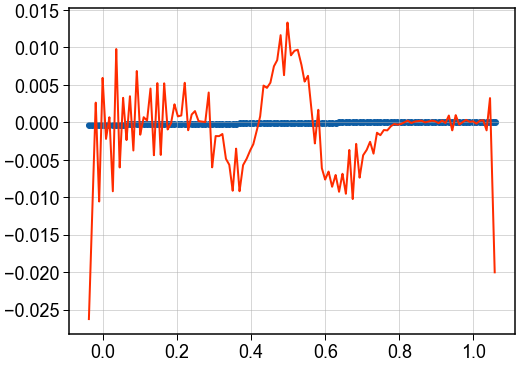

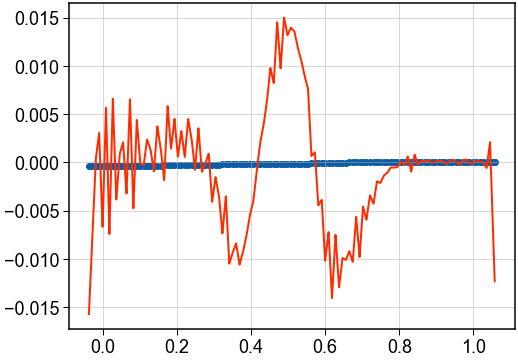

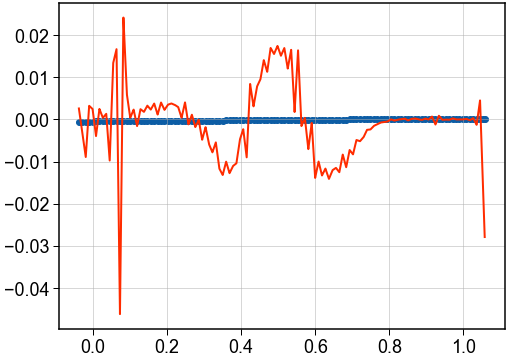

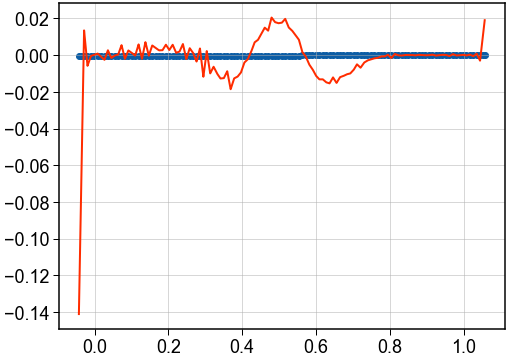

In [14]:
labels = ['400 rpm', '800 rpm', '1200 rpm', '1600 rpm']
selected_cycle = 2
ilc_est = []

for i in range(len(rpm_series)):
    # Separate forward and reverse scans
    scan_direction_bools = []
    for k in range(len(rpm_series[i]['Ewe/V'])):
        if k == 0:
            scan_direction_bools.append(True)
        elif rpm_series[i]['Ewe/V'][k - 1]  < rpm_series[i]['Ewe/V'][k]:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)

    rpm_series[i]['forward'] = scan_direction_bools

smooth = 0
for i in range(len(rpm_series)):
    # Convert to RHE, current in Amps
    rpm_series[i]['E vs RHE'] = rpm_series[i]['Ewe/V'] + 0.958
    rpm_series[i]['<I>/A'] = rpm_series[i]['<I>/mA'] / 1000

    # Filter for cycle number
    cycle_df = rpm_series[i].loc[rpm_series[i]['cycle number'] == selected_cycle]


    xf, yf = cycle_df.loc[cycle_df['forward'] == True]['E vs RHE'], cycle_df.loc[cycle_df['forward'] == True]['<I>/A']
    xr, yr = cycle_df.loc[cycle_df['forward'] == False]['E vs RHE'], cycle_df.loc[cycle_df['forward'] == False]['<I>/A']

    tck = interpolate.splrep(xf, yf, k=3, s=smooth)
    x_spline = np.linspace(np.min(xf), np.max(xf), 10000)
    y_spline = interpolate.splev(x_spline, tck, der=0)
    y_spline_1der = interpolate.splev(x_spline, tck, der=2)

    fig, ax = plt.subplots()
    ax.scatter(xf, yf, label = labels[i], c='C00')
    ax.plot(x_spline, y_spline_1der, c='C01')
    # # Check the middle region
    # plt.vlines([.36, .51], -6.0e-4, 0, colors='C01')
    # ilc_est.append(rpm_series[i].loc[rpm_series[i]['E vs RHE'].between(.36, .51)]['<I>/A'].mean())
    # plt.scatter((.51+.36)/2, ilc_est[i], c='C03', marker='_', s=300)
    #
    #
    #
    # # ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    # ax.set_xlabel('$E$ vs. RHE / V')
    # ax.set_ylabel('$i$ / A')
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # fig.legend(loc=(0.75, 0.78))
    # fig.tight_layout()
    plt.show()